**Author: Hanzhi Helen Tan**

Task refering link: https://docs.google.com/document/d/10jZ7aubVkfkcpURQQnvrvbC7o3XgglsJwjS0UA7SRBE/edit

Task: simulate transit exoplanet flux, and train a binary classifier to determine whether there exist a transit planet

# Data Simulation


There're a few important parameters that describes the 2D Transit curve (Flux vs Time) of an exoplanet (I want to ignore the limb darkening in that state):

*   Transition Duration $T = (T_{IV} - T_{I}) - τ = T_o \sqrt{1-b^2}$ and  
$ T_o = \dfrac{R_*P}{π a} ≈ 13hr (\dfrac{P}{1yr})^{1/3} (\dfrac{ρ_*}{ρ_\odot})^{-1/3}$
    * (P as period, b as impact parameter, $ρ_*$ as the density of the star)
*   Transition Depth $δ = (R_p/R_s)^2 = k^2$
*   Ingress/engress length $τ = 2*R_p$

**Goals**:

1. The simulator should be able to decide whether there exist a planet given a transition curve
2. If so, Given the Radius of the star, it should be able to calculate a few key parameters of the exoplanet: eg. $R_p, T$

**Steps**:

Transiting Flux:

1. Generate 2D transition curve, a 1d array representing flux.
2. Add Noise to the data, I choose Gaussian Distribution to do so.
3. randomly shift the transition curve left/rightward within the range to include the full transition process

Non-transiting Flux:

1. To simulate behavior of other transiting objects, I create random spikes in the flux spectrum.
2. add gaussian noise to the data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def create_transition_curve(rho_star=1410, P_year=1, R_star=6.955e8, b=0, k=0.1, noise_level=9e-4):
    """
        Parameters
            rho_star: Density of the star in kg/m^3
            P_year: Orbital period in Earth years
            R_star: Radius of the Sun in meters
            b = 0: Impact parameter
            k = 0.1: Radius ratio (Rp/Rs)
            noise_level: generate gaussian noise on the flux
        Return Values
            time_hours: 0=the center of the transition, in hour unit
            flux: 1-d array, normalized flux
    """
    # Constants for the simulation
    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2

    # period to seconds
    P = P_year * 365.25 * 24
    To_hours = 13 * (P_year)**(1/3) * (rho_star / rho_star)**(-1/3)
    tau_hours = To_hours / 10  # Ingress/Egress duration in hours, assuming 10% of total transit for simplicity

    pre_post_transit_duration_hours = To_hours  # Same duration as the transit for pre and post periods
    total_duration_hours = 2 * pre_post_transit_duration_hours + To_hours
    time_hours = np.linspace(-total_duration_hours / 2, total_duration_hours / 2, 3000)

    shift = np.random.uniform(-pre_post_transit_duration_hours / 2, pre_post_transit_duration_hours / 2)
    time_hours += shift

    flux = np.ones_like(time_hours)
    ingress_indices = (-To_hours/2 <= time_hours) & (time_hours < -To_hours/2 + tau_hours)
    egress_indices = (To_hours/2 - tau_hours < time_hours) & (time_hours <= To_hours/2)
    full_transit_indices = (-To_hours/2 + tau_hours <= time_hours) & (time_hours <= To_hours/2 - tau_hours)
    flux[full_transit_indices] = 1 - k**2

    flux[ingress_indices] = 1 - (time_hours[ingress_indices] - (-To_hours/2)) / tau_hours * k**2
    flux[egress_indices] = 1 - ((To_hours/2) - time_hours[egress_indices]) / tau_hours * k**2

    if noise_level > 0:
        flux += np.random.normal(0, noise_level, flux.shape)

    return time_hours, flux


3000


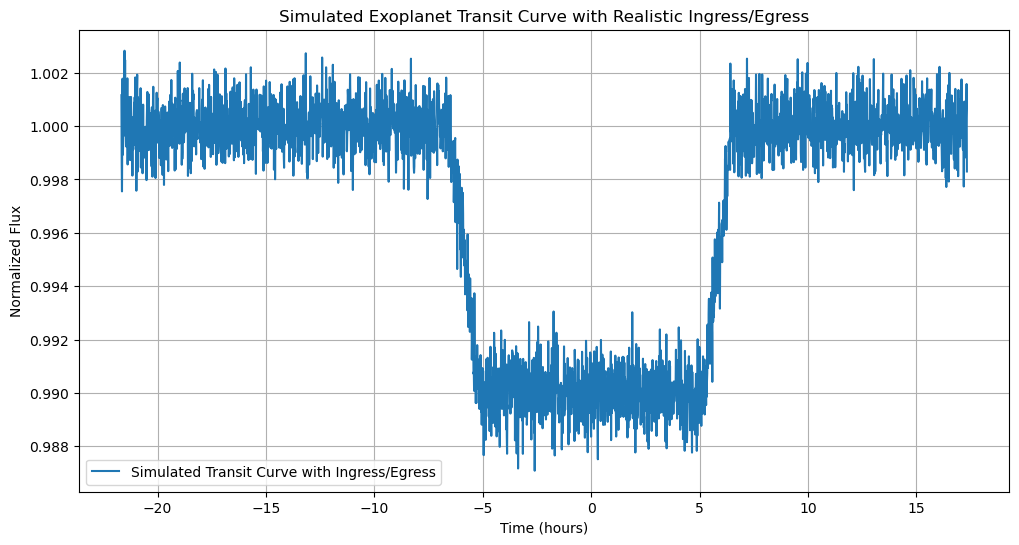

In [23]:

# Plotting
time_hours, flux = create_transition_curve(noise_level = 9e-4)
print(len(flux))
plt.figure(figsize=(12, 6))
plt.plot(time_hours, flux, label='Simulated Transit Curve with Ingress/Egress')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')
plt.title('Simulated Exoplanet Transit Curve with Realistic Ingress/Egress')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# negative (no transit set creation)
def create_random_spikes_spectrum(time_range_hours=30, num_spikes=5, spike_height=0.01, spike_width=0.1, noise_level= 9e-4):
    """
    Generates a synthetic spectrum with random spikes and Gaussian noise.

    Parameters:
        time_range_hours: Total duration of the observation in hours.
        num_spikes: Number of random spikes to be added.
        spike_height: Maximum height of the spikes.
        noise_level: Standard deviation of Gaussian noise added to the spectrum.

    Returns:
        time_hours: Time array over the observation duration in hours.
        flux: 1-d array, normalized flux with random spikes and added Gaussian noise.
    """
    time_hours = np.linspace(-time_range_hours / 2, time_range_hours / 2, 3000)
    flux = np.ones_like(time_hours) + np.random.normal(0, noise_level, time_hours.shape)

    # Add random spikes
    for _ in range(num_spikes):
        spike_position = np.random.randint(0, len(time_hours))
        current_spike_height = np.random.uniform(0, spike_height)
        gaussian_spike = np.exp(-0.5 * ((time_hours - time_hours[spike_position]) ** 2 / (spike_width ** 2)))
        flux += gaussian_spike * current_spike_height

    return time_hours, flux

3000 3000


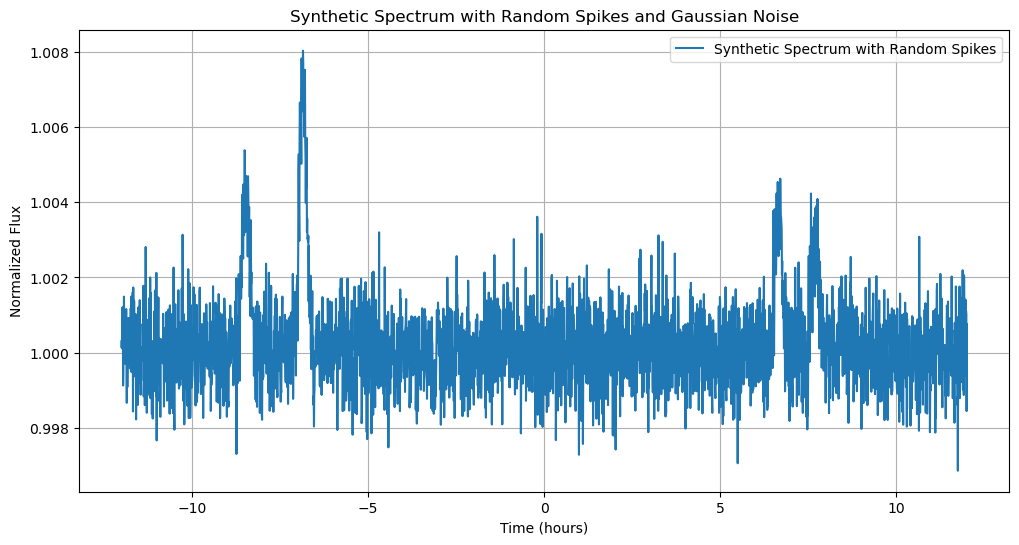

In [25]:

# Example usage
time_hours, flux = create_random_spikes_spectrum(time_range_hours=24, num_spikes=5)
print(len(flux), len(time_hours))
plt.figure(figsize=(12, 6))
plt.plot(time_hours, flux, label='Synthetic Spectrum with Random Spikes')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')
plt.title('Synthetic Spectrum with Random Spikes and Gaussian Noise')
plt.legend()
plt.grid(True)
plt.show()


**Final Data Generation**:

1. I use the sun as the default star setting for simplicity purpose
2. for orbit period and planet radius, I use the same dataset for the other (transmission spectra) task. I ignore the observational bias and refer to https://iopscience.iop.org/article/10.3847/1538-4357/ab5187 / Exoplanet Population Observation Simulator for the model. I use Kepler DR25 for the real world distribution, and Monte-Carlo method for the simulation. (I comment out the data creation process)
3. I generate 50% of transiting planet data and 50% of regular star flux

In [ ]:
# ##distribution of the observed data
# %matplotlib inline
# epos= EPOS.epos(name='example_1')
# obs, survey= EPOS.kepler.dr25(Huber=True, Vetting=True, score=0.9)
# epos.set_parametric(EPOS.fitfunctions.brokenpowerlaw2D)
# epos.set_survey(**survey)
# epos.set_observation(**obs)
# EPOS.plot.survey.observed(epos, NB=True, PlotBox=False)
# epos.fitpars.add('pps',             2.0,    min=0,                  isnorm=True)

# epos.fitpars.add('P break', 10.,    min=2,  max=50, is2D=True)
# epos.fitpars.add('a_P',             1.5,    min=0,                  is2D=True)
# epos.fitpars.add('b_P',             0.0,    dx=0.1,                 is2D=True)
# epos.fitpars.add('R break', 3.0,    min=1.0,max=5,  is2D=True)
# epos.fitpars.add('a_R',             0.0,    dx=0.1,                 is2D=True)
# epos.fitpars.add('b_R',             -4.,    fixed=True,     is2D=True)
# epos.set_ranges(xtrim=[0,730],ytrim=[0.3,20.],xzoom=[2,400],yzoom=[1,6], Occ=True)
# EPOS.run.once(epos)
# EPOS.run.mcmc(epos, nMC=5000, nwalkers=100, nburn=200, threads=20, Saved=True)
# epos.set_bins(xbins=[[2,400],[0.9*365,2.2*365]], ybins=[[1,6],[0.7,1.5]]) # eta_zoom, eta_earth
# EPOS.occurrence.all(epos)

Combined array loaded from: /Users/hanzhitan/Desktop/gsoc/p_r.npy
Combined array: [ 9.40419719 36.6125478  16.78788205 ...  1.27792703  0.54257975
  1.94724578]


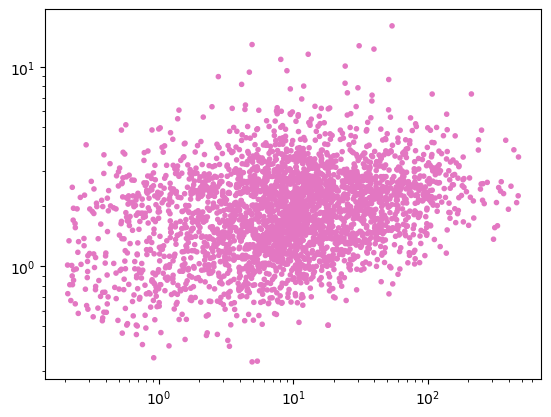

In [27]:
file_path = "/Users/hanzhitan/Desktop/gsoc/p_r.npy"
combined_array = np.load(file_path)
print("Combined array loaded from:", file_path)
print("Combined array:", combined_array)
n = combined_array.shape[0] // 2  # assuming combined_array is a 1D array
simulated_periods = combined_array[:n]
simulated_radii = combined_array[n:]
plt.scatter(simulated_periods, simulated_radii, ls='', marker='.', color='C6') # period - in days, radii - in radius of earth
plt.xscale('log')
plt.yscale('log')

In [28]:
import numpy as np
import matplotlib.pyplot as plt

rho_sun = 1410  # Density of the sun in kg/m^3
R_sun = 6.955e8  # Radius of the sun in meters

# Function to convert period (days) and radius (earth radii) to years and meters
def convert_units(period_days, radius_earth_radii):
    period_years = period_days / 365.25
    radius_meters = radius_earth_radii * (6.3781e6)  # Earth radius in meters
    return period_years, radius_meters / R_sun

simulated_periods_years = convert_units(simulated_periods, 0)[0]
simulated_radii_ratio = convert_units(0, simulated_radii)[1]

def create_flux_data_for_planet(period_year, radius_ratio, label):
    impact_parameters = np.random.uniform(0, 1, size=n)
    _, flux = create_transition_curve(rho_star=rho_sun, P_year=period_year, R_star=R_sun, b=impact_parameters, k=radius_ratio)
    return flux, label

# Function to generate dataset
def generate_dataset(num_no_transit):
    data_flux = []
    data_labels = []
    
    # Transiting planets
    for period_year, radius_ratio in zip(simulated_periods_years, simulated_radii_ratio):
        flux, label = create_flux_data_for_planet(period_year, radius_ratio, 1)
        data_flux.append(flux)
        data_labels.append(1)
        
        _, flux = create_random_spikes_spectrum()
        data_flux.append(flux)
        data_labels.append(0)  # Label for non-transit
    
    return np.array(data_flux), np.array(data_labels)

num_no_transit = len(simulated_periods)  # Assuming equal number of non-transit scenarios
print(num_no_transit)
data_flux, data_labels = generate_dataset(num_no_transit)

np.save("/Users/hanzhitan/Desktop/gsoc/transit_data_flux.npy", data_flux)
np.save("/Users/hanzhitan/Desktop/gsoc/transit_data_labels.npy", data_labels)


3056


0


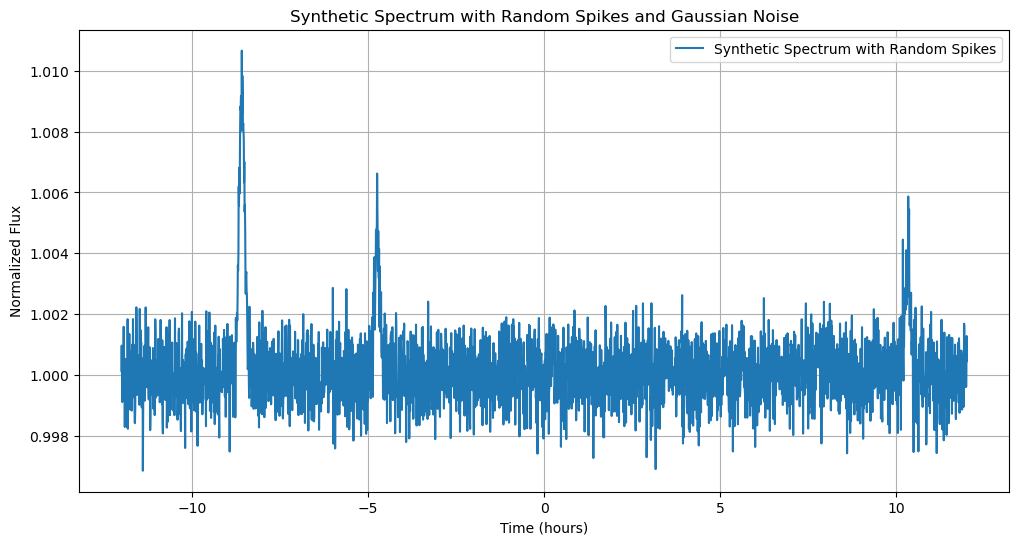

1


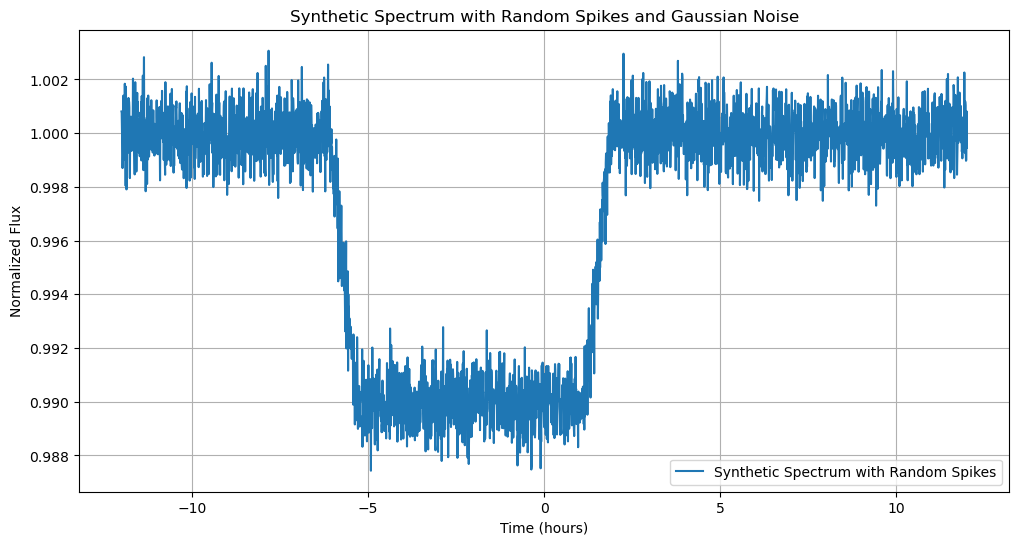

1


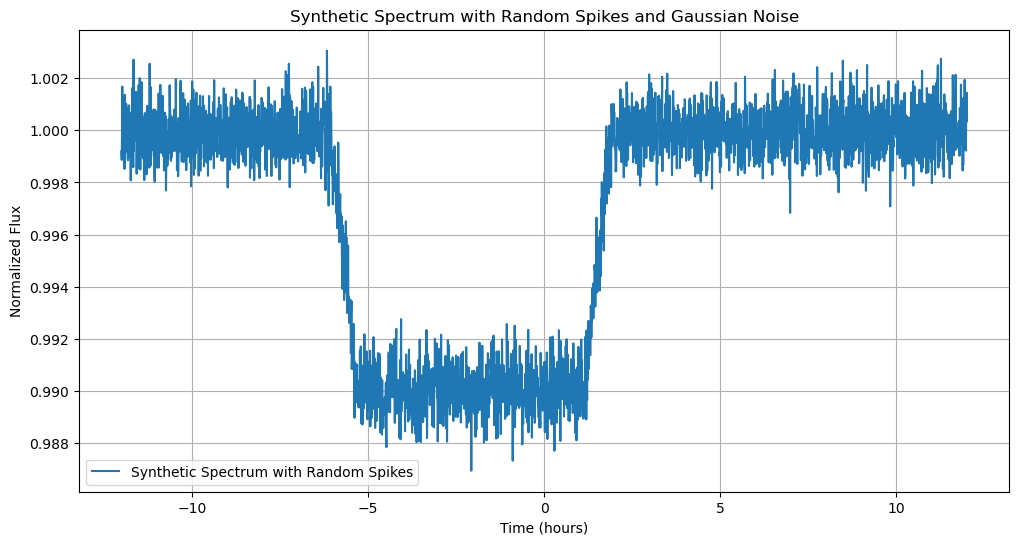

1


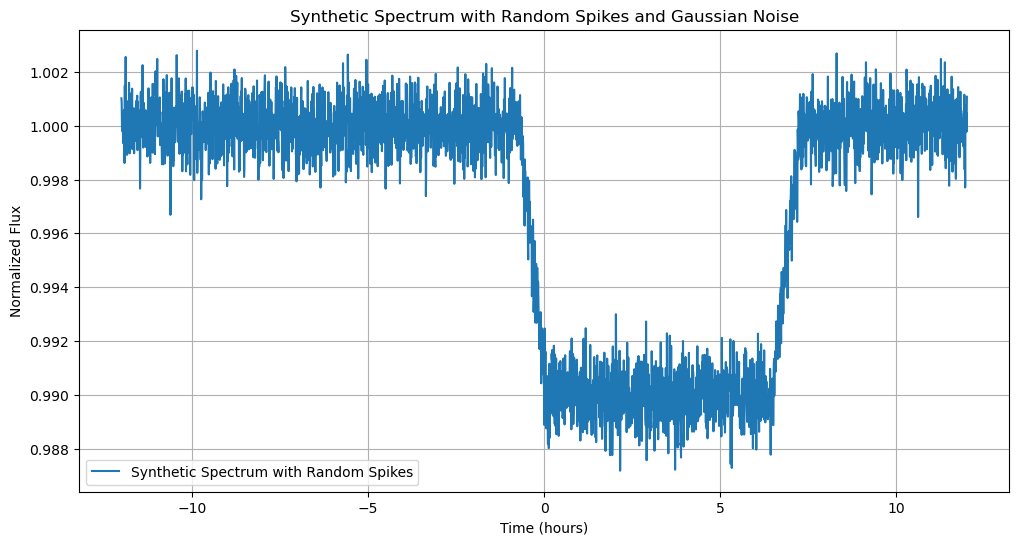

0


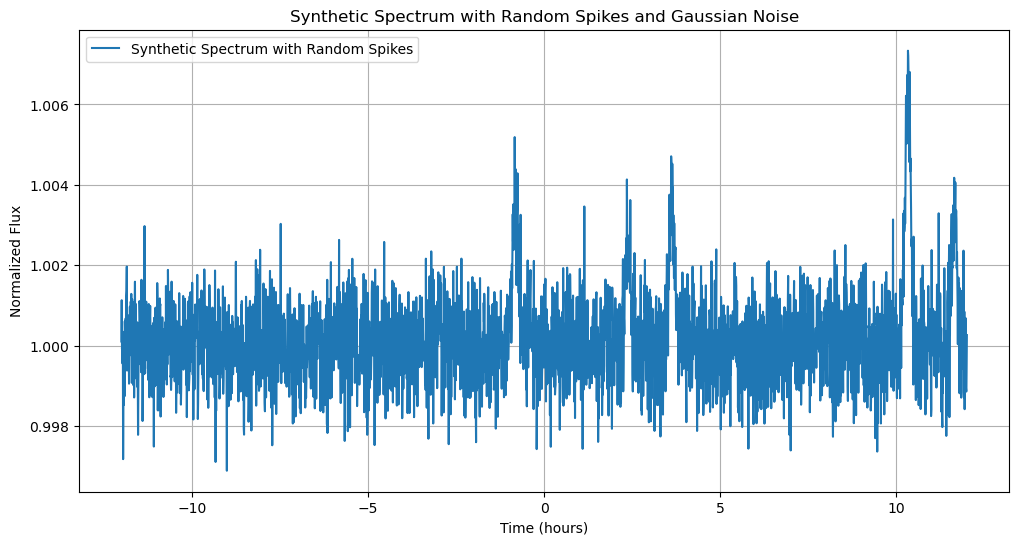

In [29]:
for i in range(5):
    print(labels[i])
    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, data[i], label='Synthetic Spectrum with Random Spikes')
    plt.xlabel('Time (hours)')
    plt.ylabel('Normalized Flux')
    plt.title('Synthetic Spectrum with Random Spikes and Gaussian Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

## Prediction / Classification

I use a dense neural network to handle this problem, a few techniques has been applied to increase accurary:
1. Dropout: At each hidden layer, dropout is applied at a rate of 0.5. 
2. Batch Normalization: to stabilize the learning process and  reduce the number of training epochs required to train deep networks. 
3. L2 Regularization: The model applies L2 regularization to the kernel weights of each hidden layer, penalizing large weights to encourage simpler models that are less likely to overfit.
4. decrease learning rate: reduces the learning rate when the validation loss stops improving

Validation loss and training loss have decreased constantly, and I reach final test accuracy around 82%

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [31]:
data = np.load("/Users/hanzhitan/Desktop/gsoc/transit_data_flux.npy")
labels = np.load("/Users/hanzhitan/Desktop/gsoc/transit_data_labels.npy")

In [54]:
data, labels = shuffle(data, labels, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Further splitting for validation

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=2e-4), loss='mse', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[reduce_lr]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5583 - loss: 5.4583 - val_accuracy: 0.5229 - val_loss: 9.7632 - learning_rate: 2.0000e-04
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5585 - loss: 4.8576 - val_accuracy: 0.5229 - val_loss: 4.4482 - learning_rate: 2.0000e-04
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5867 - loss: 4.1776 - val_accuracy: 0.5229 - val_loss: 1.7162 - learning_rate: 2.0000e-04
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5472 - loss: 4.1252 - val_accuracy: 0.5229 - val_loss: 1.9940 - learning_rate: 2.0000e-04
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5816 - loss: 3.6722 - val_accuracy: 0.5229 - val_loss: 15.1014 - learning_rate: 2.0000e-04
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6043 - loss: 3.2167 - val_accuracy: 0.5229 - val_loss: 10.3984 - learning_rate: 2.0000e-04
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[ 0.5854621   0.81047815  0.02847521  0.78131664  0.5702296   0.07540908
  1.1015955   0.03844779  0.8183926   0.28395337  0.6252808   0.85006917
  0.47317606  0.6531399   0.41547984 -0.30426115  0.11517859  0.9423343
  0.43906695  0.5635493 ]
[1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1]


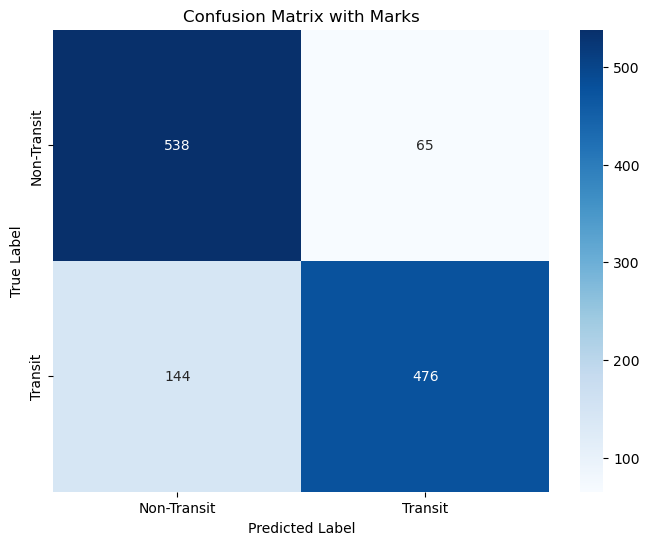

In [58]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)
print(y_pred.flatten()[:20])
print(y_test[:20])
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Transit', 'Transit'], yticklabels=['Non-Transit', 'Transit'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Marks')
plt.show()

In [60]:
model.save('/Users/hanzhitan/Desktop/gsoc/transit_classification.keras')  # Saves the model to a SavedModel directory
